# Performance Figure
This notebook collects results from different GCN Multi-Omics trainings as well as HotNet2 and MutSigCV. It then shows the performance of all those methods as a scatterplot.
Each method in this plot represents a point and its coordinates represent the performance of it.
The x-axis depicts the performance on the known cancer genes (training + set set for GCN) and the y-axis depicts the performance on the candidate cancer genes from the NCG.

**Different metrics can be chosen to measure the performance. Currently, precision, recall, AUPR and F1 score can be used.**

Metrics:

* Precision measures the fraction of cancer genes out of all genes that were predicted by the algorithm
* Recall measures the fraction of cancer genes that were found (out of all the cancer genes)
* AUPR measures the area under the precision recall curve, so it incorporates both scores

In [1]:
import pandas as pd
import numpy as np
import os, sys
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO, postprocessing
sys.path.append(os.path.abspath('../pagerank'))
import pagerank

import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import upsetplot
import seaborn as sns
%matplotlib inline

## Relevant Paths
* `ncg_cancer_gene_path`: The path where NCG known cancer genes and candidate cancer genes are stored
* `oncokb_cancer_gene_path`: The path where the oncoKB database is stored
* `baileyetal_cancer_gene_path`: The path where cancer genes from Bailey et al., 2018 are stored
* `driverdb_cancer_gene_path`: The path to the driverDB database folder. It should contain subfolders for the different evidence types (`mutation_download_tab`, `CNV_download_tab` or `methylation_download_tab`)
* `ongene_oncogenes_path`: The path to ONGene oncogenes
* `tsgene_tsgs_path`: The path to TSGene tumor suppressor genes
* `digsee_*_path`: The path to cancer genes from DigSEE. They did literature-mining based on evidence and therefore, there are 3 different subfolders for gene expression, DNA methylation and mutation derived cancer genes

In [2]:
ncg_cancer_gene_path = '../data/pancancer/NCG/cancergenes_list.txt'
oncokb_cancer_gene_path = '/project/gcn/diseasegcn/data/pancancer/oncoKB/cancerGeneList.txt'
baileyetal_cancer_gene_path = '../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv'
driverdb_cancer_gene_path = '../data/pancancer/driverdb/'
ongene_oncogenes_path = '../data/pancancer/ongene_tsgene/Human_Oncogenes.txt'
tsgene_tsgs_path = '../data/pancancer/ongene_tsgene/Human_TSGs.txt'
digsee_expression_path = '/project/gcn/diseasegcn/data/pancancer/digSEE/expression/'
digsee_mutation_path = '/project/gcn/diseasegcn/data/pancancer/digSEE/mutation/'
digsee_methylation_path = '/project/gcn/diseasegcn/data/pancancer/digSEE/methylation/'

## Directories of Stored EMOGI Models

In [3]:
# get metrics from different multi-omics trainings
dir_multinet = '../data/GCN/training/final_TCGA_all_networks/Multinet/'
dir_cpdb = '../data/GCN/training/final_TCGA_all_networks/CPDB/'
dir_iref = '../data/GCN/training/final_TCGA_all_networks/IRefIndex_old/'
dir_string = '../data/GCN/training/final_TCGA_all_networks/STRING-db/'
dir_irefnew = '../data/GCN/training/final_TCGA_all_networks/IRefIndex/'
dir_pcnet = '../data/GCN/training/final_TCGA_all_networks/PCNet/'

In [4]:
def get_metrics_for_training(data_dir, metric='recall', digsee_sets=False, errorbars=False):
    all_metrics = []
    data_types = []
    for d in os.listdir(data_dir):
        training_dir = os.path.join(data_dir, d)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            metrics = get_metrics_for_single_training(training_dir, metric=metric, digsee_sets=digsee_sets, errorbars=errorbars)
            all_metrics.append(metrics)
            data_types.append(d)
    return all_metrics, data_types

def get_metrics_for_single_training(training_dir, metric='recall', digsee_sets=False, errorbars=False):
    if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
        cv_runs = gcnIO.load_hyper_params(training_dir)[0]['cv_runs']
        data = postprocessing.get_training_data(training_dir)
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        pred = postprocessing.get_predictions(training_dir)
        cutoff = postprocessing.get_optimal_cutoff(pred, node_names, test_mask, y_test)
        oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(training_dir)

        if errorbars:
            oncokb_metric = []
            ncg_cand_metric = []
            for run in range(1, cv_runs+1):
                oncokb_local, ncg_cand_local = postprocessing.get_metric_score(pred, node_names, oncoKB, ncg_cand,
                                                                               cutoff, metric=metric,
                                                                               colname='Prob_pos_{}'.format(run))
                oncokb_metric.append(oncokb_local)
                ncg_cand_metric.append(ncg_cand_local)
        else:
            test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
            genes_negtest = node_names[test_neg, 1] # get the gene names
            oncokb_metric, ncg_cand_metric = postprocessing.get_metric_score(pred, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
        
        if digsee_sets:
            ds_mut, ds_meth, ds_expr = get_all_digsee_sets(training_dir)
            if errorbars:
                ncg_known_metric = []
                ds_mut_metric = []
                ds_meth_metric = []
                ds_expr_metric = []
                for run in range(1, cv_runs+1):
                    ds_mut_loc, ds_meth_loc = postprocessing.get_metric_score(pred, node_names, ds_mut, ds_meth, cutoff, None,
                                                                              metric, colname='Prob_pos_{}'.format(run))
                    ds_expr_loc, ncg_known_loc = postprocessing.get_metric_score(pred, node_names, ds_expr, ncg_known, cutoff, None,
                                                                                 metric, colname='Prob_pos_{}'.format(run))
                    ncg_known_metric.append(ncg_known_loc)
                    ds_mut_metric.append(ds_mut_loc)
                    ds_meth_metric.append(ds_meth_loc)
                    ds_expr_metric.append(ds_expr_loc)
            else:
                ds_mut_metric, ds_meth_metric = postprocessing.get_metric_score(pred, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
                ds_expr_metric, ncg_known_metric = postprocessing.get_metric_score(pred, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
            return ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric
        else:
            return ncg_cand_metric, oncokb_metric

def get_cancer_genes_for_net(model_dir):
    if model_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(model_dir)
    else:
        data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    nodes['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)
    # to exclude them from other databases
    known_drivers = node_names[np.logical_or(y_train.reshape(-1), y_test.reshape(-1)), 1]
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open(ncg_cancer_gene_path, 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

    oncokb_genes = pd.read_csv(oncokb_cancer_gene_path, sep='\t')
    # remove low confidence genes
    oncokb_no_ncg_highconf = oncokb_genes#[oncokb_genes['OncoKB Annotated'] == 'Yes']
    oncokb_no_ncg_highconf = oncokb_no_ncg_highconf[oncokb_no_ncg_highconf['# of occurrence within resources (Column D-J)'] >= 3]
    # remove all NCG genes
    oncokb_no_ncg = oncokb_no_ncg_highconf[~oncokb_no_ncg_highconf['Hugo Symbol'].isin(known_cancer_genes_innet)]
    candidate_cancer_genes_innet = candidate_cancer_genes_innet[~candidate_cancer_genes_innet.isin(oncokb_no_ncg)]
    #oncokb_no_ncg = oncokb_no_ncg[~oncokb_no_ncg['Hugo Symbol'].isin(candidate_cancer_genes_innet)]
    # remove genes that are not in the network
    oncokb_innet = nodes[nodes.Name.isin(oncokb_no_ncg['Hugo Symbol'])].Name
    
    # comprehensive characterization paper genes
    cancer_genes_paper = pd.read_csv(baileyetal_cancer_gene_path, sep='\t', header=3)
    cancer_genes_paper = pd.Series(cancer_genes_paper.Gene.unique())
    cancer_genes_paper_notrain = cancer_genes_paper[~cancer_genes_paper.isin(known_drivers)]
    cancer_genes_paper_innet = nodes[nodes.Name.isin(cancer_genes_paper_notrain)].Name
    
    # driverDB
    driverdb_genes = []
    thresholds_study = {'mutation': 25, 'CNV': 5, 'methylation': 2}
    for evidence in ['mutation', 'CNV', 'methylation']:
        driverdb_data = pd.read_csv(os.path.join(driverdb_cancer_gene_path, '{}_download_tab.txt'.format(evidence)), sep='\t')
        all_driver_genes = []
        for index, row in driverdb_data.iterrows():
            all_driver_genes += [i.strip() for i in row.driver_gene.split(',') if not i.strip() == '']
        study_counts = pd.Series(all_driver_genes).value_counts()
        driverdb_genes += list(study_counts[study_counts > thresholds_study[evidence]].index)
    driverdb_genes = pd.Series(list(set(driverdb_genes)))
    driverdb_genes_notrain = driverdb_genes[~driverdb_genes.isin(known_drivers)]
    driverdb_innet = nodes[nodes.Name.isin(driverdb_genes_notrain)].Name

    # OnGene + TSGene
    oncogenes = pd.read_csv(ongene_oncogenes_path, sep='\t')
    tsgs = pd.read_csv(tsgene_tsgs_path, sep='\t')
    cancer_genes = list(set(list(oncogenes.OncogeneName) + list(tsgs.GeneSymbol)))
    oncotsgs_innet = nodes[nodes.Name.isin(cancer_genes)].Name
    oncotsgs_innet = oncotsgs_innet[~oncotsgs_innet.isin(known_drivers)]
    oncogenes_innet = oncotsgs_innet[oncotsgs_innet.isin(oncogenes.OncogeneName)]
    tsgs_innet = oncotsgs_innet[oncotsgs_innet.isin(tsgs.GeneSymbol)]

    return cancer_genes_paper_innet, candidate_cancer_genes_innet, known_cancer_genes_innet


def _get_digsee_genes(base_dir, nodes, to_be_removed, threshold):
    pan_cancer_genes = []
    for f in os.listdir(base_dir):
        if f.startswith('mutation') or f.startswith('expression') or f.startswith('methylation'):
            ctype = f.split('.')[0].split('_')[1]
            fname = os.path.join(base_dir, f)
            evidence = pd.read_csv(fname, sep='\t')
            high_scores = evidence[evidence['EVIDENCE SENTENCE SCORE'] >= threshold]
            pan_cancer_genes += high_scores['GENE SYMBOL'].tolist()
    pan_cancer_genes_filtered = [i for i in pan_cancer_genes if not i in to_be_removed]
    return nodes[nodes.Name.isin(pan_cancer_genes)].Name


def get_all_digsee_sets(train_dir, threshold=0.3):
    if train_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(train_dir)
    else:
        data = postprocessing.get_training_data(train_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    to_be_removed = nodes[np.logical_or(y_train.reshape(-1), y_test.reshape(-1))].Name
    
    expr_genes = _get_digsee_genes(digsee_expression_path, nodes, to_be_removed, threshold)
    """
    meth_genes = _get_digsee_genes(digsee_methylation_path, nodes, to_be_removed, threshold)
    muta_genes = _get_digsee_genes(digsee_mutation_path, nodes, to_be_removed, threshold)
    """
    
    oncogenes = pd.read_csv(ongene_oncogenes_path, sep='\t')
    oncogenes_innet = nodes[nodes.Name.isin(oncogenes.OncogeneName)].Name
    oncogenes_final = oncogenes_innet[~oncogenes_innet.isin(to_be_removed)]
    
    bailey = pd.read_csv(baileyetal_cancer_gene_path, sep='\t', header=3)
    bailey = pd.Series(bailey.Gene.unique())
    bailey_notrain = bailey[~bailey.isin(to_be_removed)]
    bailey_final = nodes[nodes.Name.isin(bailey_notrain)].Name
    
    return oncogenes_final, bailey_final, expr_genes


def get_metric_for_mutsigcv(model_dir, metric='recall', digsee_sets=False):
    # get the basic data
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # get the MutSigCV scores
    mutsigcv_scores = pd.read_csv('../data/pancancer/mutsigcv/mutsigcv_genescores.csv',
                                  index_col=0, sep='\t').max(axis=1)
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    mutsigcv_scores_filled = mutsigcv_scores.reindex(nodes.Name).fillna(0)
    mutsigcv_df = pd.DataFrame(mutsigcv_scores_filled, columns=['Mean_Pred'])
    mutsigcv_df['Name'] = mutsigcv_df.index
    mutsigcv_df['label'] = y_test

    # get sets and compute metrics
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    cutoff = postprocessing.get_optimal_cutoff(mutsigcv_df, node_names, test_mask, y_test)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncokb_metric, ncg_cand_metric = postprocessing.get_metric_score(mutsigcv_df, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = postprocessing.get_metric_score(mutsigcv_df, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = postprocessing.get_metric_score(mutsigcv_df, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        return ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric
    else:
        return ncg_cand_metric, oncokb_metric

def get_hotnet2_results():
    hotnet2_results = {}
    with open('../data/pancancer/hotnet2/hotnet2_results/hotnet2_subnetworks.csv', 'r') as f:
        current_network = None
        current_datatype = None
        all_genes_current = []
        counter = 0
        for line in f.readlines():
            if line.split('\t')[0] in ['HINT+HI2012', 'iRefIndex', 'Multinet']:
                if current_network is None or len(all_genes_current) == 0:
                    pass
                else:
                    hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
                current_network = line.split('\t')[0]
                current_datatype = line.split('\t')[1]
                all_genes_current = []
            if current_network is None:
                continue
            genes = [i.strip() for i in line.split('\t')[2:] if not i in ['', '\n']]
            all_genes_current += genes
        hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
    return hotnet2_results

def compute_hotnet2_metrics(metric='recall', digsee_sets=False):
    collected = []
    datatypes = []
    networks = []
    hotnet2_results = get_hotnet2_results()
    for key in hotnet2_results:
        res_df = pd.DataFrame(hotnet2_results[key], columns=['Name'])
        res_df['Mean_Pred'] = 1
        if key.split('_')[0] == 'Multinet':
            data_dir = dir_multinet
            net = 'Multinet'
        elif key.split('_')[0] == 'iRefIndex':
            data_dir = dir_iref
            net = 'IREF'
        else:
            continue
        # load data for the run
        data = postprocessing.get_training_data(os.path.join(data_dir, 'multiomics'))
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
        res_df_hotnet2 = res_df.set_index('Name').reindex(nodes.Name).fillna(0)
        res_df_hotnet2['Name'] = res_df_hotnet2.index
        
        # get some information on the current run
        datatype = 'Hotnet2 ({} Scores)'.format(key.split('_')[1])
        datatypes.append(datatype)
        networks.append(net)

        oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(data_dir, 'multiomics'))
        test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
        genes_negtest = node_names[test_neg, 1] # get the gene names
        oncokb_metric, ncg_cand_metric = postprocessing.get_metric_score(res_df_hotnet2, node_names, oncoKB, ncg_cand, 0.5, genes_negtest, metric=metric)
        if digsee_sets:
            ds_mut, ds_meth, ds_expr = get_all_digsee_sets(os.path.join(data_dir, 'multiomics'))
            ds_mut_metric, ds_meth_metric = postprocessing.get_metric_score(res_df_hotnet2, node_names, ds_mut, ds_meth, 0.5, genes_negtest, metric)
            ds_expr_metric, ncg_known_metric = postprocessing.get_metric_score(res_df_hotnet2, node_names, ds_expr, ncg_known, 0.5, genes_negtest, metric)
            collected.append([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric])
        else:
            collected.append([ncg_cand_metric, oncokb_metric])

    cols = ['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'] if digsee_sets else ['NCG_Cand', 'OncoKB']
    result = pd.DataFrame(collected, index=datatypes, columns=cols)
    result['Method'] = datatypes
    result['Network'] = networks
    result['ind'] = 'HotNet2'
    result.set_index('ind', inplace=True)
    return result

def compute_RF_metrics(model_dir, network_name, metric='recall', digsee_sets=False):
    # load the data
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    
    # prepare for scikit-learn API
    X_train = features[train_mask.astype(np.bool)]
    y_tr = y_train[train_mask.astype(np.bool)]
    X_test = features[test_mask.astype(np.bool)]

    # train RF classifier
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_tr.reshape(-1))
    predictions = rf.predict_proba(features)
    predictions = pd.DataFrame(predictions[:, 1], index=node_names[:, 1], columns=['Mean_Pred'])
    predictions['Name'] = predictions.index
    predictions['label'] = y_test
    
    cutoff = postprocessing.get_optimal_cutoff(predictions, node_names, test_mask, y_test)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    oncokb_metric, ncg_cand_metric = postprocessing.get_metric_score(predictions, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = postprocessing.get_metric_score(predictions, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = postprocessing.get_metric_score(predictions, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        perf_df = pd.DataFrame([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['RF']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['RF']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'Random Forest'
    return perf_df

def compute_PR_metrics(model_dir, network_name, metric='recall', digsee_sets=False):
    # load the data
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # train pagerank on the network
    scores, names = pagerank.pagerank(network, node_names)
    pr_df = pd.DataFrame(scores, columns=['Number', 'Mean_Pred'])
    # get the results in same order as our data
    names = pd.DataFrame(names, columns=['ID', 'Name'])
    predictions = pr_df.join(names, on='Number', how='inner')
    predictions.drop_duplicates(subset='Name', inplace=True)
    node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    predictions = predictions.set_index('Name').reindex(node_names_df.Name)
    predictions['Name'] = predictions.index
    predictions['label'] = y_test

    cutoff = postprocessing.get_optimal_cutoff(predictions, node_names, test_mask, y_test)
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncokb_metric, ncg_cand_metric = postprocessing.get_metric_score(predictions, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = postprocessing.get_metric_score(predictions, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = postprocessing.get_metric_score(predictions, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        perf_df = pd.DataFrame([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['PageRank']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['PageRank']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'PageRank'
    return perf_df
    
def compute_netprop_metrics(model_dir, network_name, metric='recall', digsee_sets=False):
    # load the data
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data

    p_0 = features[:, :16].mean(axis=1) # mean mutation frequencies
    beta = 0.3
    W = network / network.sum(axis=0) # normalize A
    np.nan_to_num(W, copy=False)
    #assert (np.allclose(W.sum(axis=0), 1)) # assert that rows/cols sum to 1
    p = np.linalg.inv(beta * (np.eye(network.shape[0]) - (1 - beta) * W)).dot(np.array(p_0))
    
    predictions = pd.DataFrame(p, index=node_names[:, 1], columns=['Mean_Pred'])
    predictions['Name'] = predictions.index
    predictions['label'] = y_test
    
    cutoff = postprocessing.get_optimal_cutoff(predictions, node_names, test_mask, y_test)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    oncokb_metric, ncg_cand_metric = postprocessing.get_metric_score(predictions, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = postprocessing.get_metric_score(predictions, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = postprocessing.get_metric_score(predictions, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        perf_df = pd.DataFrame([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['NetProp']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['NetProp']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'Net. Prop. (Mut. Freq.)'
    return perf_df

def compute_deepwalk_metrics(embedding_file, input_file, network_name, metric='recall', digsee_sets=False):
    data = gcnIO.load_hdf_data(input_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # train SVM on deepWalk embeddings
    deepwalk_embeddings = pd.read_csv(embedding_file,
                                      header=None, skiprows=1, sep=' ')

    deepwalk_embeddings.columns = ['Node_Id'] + deepwalk_embeddings.columns[1:].tolist()
    deepwalk_embeddings.set_index('Node_Id', inplace=True)
    n_df = pd.DataFrame(node_names, columns=['ID', 'Name'])
    embedding_with_names = deepwalk_embeddings.join(n_df)
    X_dw = embedding_with_names.set_index('Name').reindex(n_df.Name).drop('ID', axis=1)
    X_train_dw = X_dw[train_mask.astype(np.bool)]
    X_test_dw = X_dw[test_mask.astype(np.bool)]
    clf_dw = SVC(kernel='rbf', class_weight='balanced', probability=True, gamma='auto')
    clf_dw.fit(X_train_dw, y_train[train_mask.astype(np.bool)].reshape(-1))
    pred_deepwalk = clf_dw.predict_proba(X_dw)
    pred_dw_df = pd.DataFrame(pred_deepwalk, columns=['Pred_neg', 'Mean_Pred'], index=X_dw.index).drop('Pred_neg', axis=1)
    pred_dw_df['Name'] = pred_dw_df.index
    pred_dw_df['label'] = y_test
    cutoff = postprocessing.get_optimal_cutoff(pred_dw_df, node_names, test_mask, y_test)

    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(input_file)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncokb_metric, ncg_cand_metric = postprocessing.get_metric_score(pred_dw_df, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(input_file)
        ds_mut_metric, ds_meth_metric = postprocessing.get_metric_score(pred_dw_df, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = postprocessing.get_metric_score(pred_dw_df, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        perf_df = pd.DataFrame([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['DeepWalk']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['DeepWalk']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'DeepWalk + SVM'
    return perf_df


def compute_degree_metrics(model_dir, metric='recall', digsee_sets=False):
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    score = pd.DataFrame(network.sum(axis=1), index=node_names[:, 1], columns=['Mean_Pred'])
    score['label'] = y_test
    score['Name'] = score.index

    # get sets and compute metrics
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    cutoff = postprocessing.get_optimal_cutoff(score, node_names, test_mask, y_test)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncokb_metric, ncg_cand_metric = postprocessing.get_metric_score(score, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = postprocessing.get_metric_score(score, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = postprocessing.get_metric_score(score, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        return ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric
    else:
        return ncg_cand_metric, oncokb_metric

## Overlap of Gene Sets

In [5]:
cancer_gene_sets = postprocessing.get_all_cancer_gene_sets(ncg_path='../data/pancancer/NCG/cancergenes_list.txt',
                                                           oncoKB_path='../data/pancancer/oncoKB/cancerGeneList.txt',
                                                           baileyetal_path='../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv',
                                                           ongene_path='../data/pancancer/ongene_tsgene/Human_Oncogenes.txt'
                                                          )
ncg_knowns = cancer_gene_sets[0]
ncg_candidates = cancer_gene_sets[1]
oncoKB_genes = cancer_gene_sets[2]
baileyetal = cancer_gene_sets[3]
oncogenes = cancer_gene_sets[4]

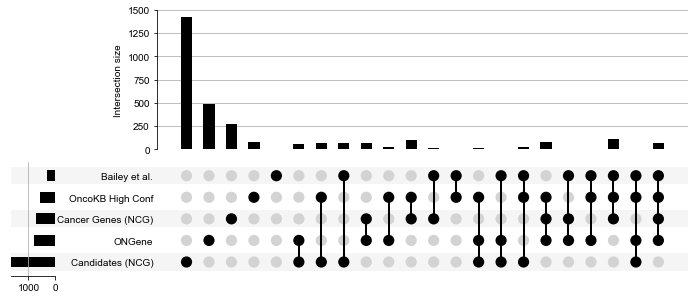

In [6]:
fig = plt.figure(figsize=(30, 20))
cancer_gene_set_dict = {#'DriverDB': list(driverdb_genes),
                        'ONGene': list(oncogenes),
                        #'TSGene': list(tsgs.GeneSymbol),
                        'Cancer Genes (NCG)': ncg_knowns,
                        'Candidates (NCG)': ncg_candidates,
                        'Bailey et al.': baileyetal,
                        'OncoKB High Conf': oncoKB_genes
                        #'COSMIC CGC': cgc
                       }
contents = upsetplot.from_contents(cancer_gene_set_dict)
_ = upsetplot.plot(contents, subset_size='auto', fig=fig)
#fig.savefig('../data/pancancer/overlap_independent_cancergenesets.svg')

## Overlap of Cancer Gene Predictions for the CPDB PPI Network

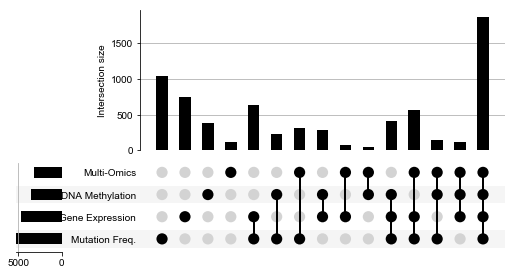

In [36]:
mapping_omics = {'expression': 'Gene Expression', 'methylation': 'DNA Methylation',
                'mutations': 'Mutation Freq.', 'multiomics': 'Multi-Omics'
                #'mutation_expression': 'Mutations & Expression',
                #'methylation_expression': 'DNA Meth. & Expression',
                #'methylation_mutation': 'DNA Meth. & Mutations.'
               }

single_omics_pred_dict = {}
for d in os.listdir(dir_cpdb):
        training_dir = os.path.join(dir_cpdb, d)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            pred_omics = postprocessing.get_predictions(training_dir)
            data = postprocessing.get_training_data(training_dir)
            network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
            cutoff = postprocessing.get_optimal_cutoff(pred_omics, node_names, test_mask, y_test)
            pred_pos_omics = pred_omics[pred_omics.Mean_Pred >= cutoff]
            if d in mapping_omics:
                single_omics_pred_dict[mapping_omics[d]] = list(pred_pos_omics.Name)

fig = plt.figure(figsize=(20, 40))
contents = upsetplot.from_contents(single_omics_pred_dict)
_ = upsetplot.plot(contents, subset_size='auto', fig=fig)
fig.savefig(os.path.join(dir_cpdb, 'overlap_omics_predictions.svg'))

## Joint Performance for All Tools on Test Set

In [9]:
def compute_metric(y_true, y_pred, metric='aupr', cutoff=0.5):
    if metric == 'recall':
        return recall_score(y_true=y_true, y_pred=y_pred >= cutoff)
    elif metric == 'aupr':
        return average_precision_score(y_true=y_true, y_score=y_pred)
    elif metric == 'auroc':
        return roc_auc_score(y_true=y_true, y_score=y_pred)
    elif metric == 'precision':
        return precision_score(y_true=y_true, y_pred=y_pred >= cutoff)
    else:
        print ("Metric {} unknown!".format(metric))
        return None

def get_threshold(y_true, y_pred):
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
    pr = pr[1:]
    rec = rec[1:]
    thresholds = thresholds[1:]
    distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
    idx = np.argmin(distances)
    best_threshold = thresholds[idx]
    return best_threshold


training_runs = {'Multinet': dir_multinet,
                 'CPDB': dir_cpdb,
                 'IREF':dir_iref,
                 'STRING-db': dir_string,
                 'IREF (New)': dir_irefnew,
                 'PCNet': dir_pcnet
                }
name2ppiname = {'Multinet': 'Multinet', 'CPDB': 'CPDB', 'IREF': 'IREF', 'IREF (New)': 'IREFNew', 'STRING-db': 'string', 'PCNet': 'PCNet'}
methods = [('EMOGI', 'EMOGI'), ('Random Forest', 'Random_Forest'),
           ('DeepWalk + SVM', 'DeepWalk'),
           ('PageRank', 'PageRank'), ('Net. Prop.', 'RWR'),
           ('MutSigCV', 'MutSigCV')]
ppi_networks = ['CPDB', 'IREF (New)', 'STRING-db', 'Multinet', 'PCNet', 'IREF']
metrics_all = pd.DataFrame(index=[m[0] for m in methods])

for ppi_network in ppi_networks:
    performance_all, performance_test = postprocessing.compute_predictions_competitors(model_dir=os.path.join(training_runs[ppi_network], 'multiomics'),
                                                                                       network_name=name2ppiname[ppi_network], network_measures=False,
                                                                                       plot_correlations=False, verbose=True)
    
    data = postprocessing.get_training_data(os.path.join(training_runs[ppi_network], 'multiomics'))
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    _, _, knowns = get_cancer_genes_for_net(os.path.join(training_runs[ppi_network], 'multiomics'))
    # compute area under PR curve
    metric_values = []
    for name, colname in methods:
        cutoff = 0.5
        #cutoff = get_threshold(y_true=y_test[test_mask == 1, 0], y_pred=performance_test[colname])
        all_knowns = performance_all[performance_all.index.isin(knowns)]
        recovered = all_knowns[all_knowns[colname] >= cutoff].shape[0] / all_knowns.shape[0]
        #metric = compute_metric(y_true=y_test[test_mask == 1, 0], y_pred=performance_test[colname],
        #                        metric='recall', cutoff=cutoff
        #                       )
        #aupr = average_precision_score(y_true=y_test[test_mask == 1, 0], y_score=performance_test[colname])
        metric_values.append(recovered)
    print ("Computations for {} completed!".format(ppi_network))
    metrics_all[ppi_network] = metric_values
    
    if ppi_network == 'CPDB':
        performance_cpdb = performance_all

metrics_all.columns = ['IRefIndex\n(2015)' if i == 'IREF' else i for i in metrics_all.columns]
metrics_all.columns = ['IRefIndex' if i == 'IREF (New)' else i for i in metrics_all.columns]

Number of predicted genes in Test set (RF): 62
RF predicts 1567 genes in total
Number of predicted genes in Test set (LogReg): 263
LogReg predicts 5430 genes in total


/project/gcn/diseasegcn/EMOGI/postprocessing.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for CPDB completed!
Number of predicted genes in Test set (RF): 31
RF predicts 1119 genes in total
Number of predicted genes in Test set (LogReg): 395
LogReg predicts 6775 genes in total


/project/gcn/diseasegcn/EMOGI/postprocessing.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for IREF (New) completed!
Number of predicted genes in Test set (RF): 88
RF predicts 1908 genes in total
Number of predicted genes in Test set (LogReg): 297
LogReg predicts 5829 genes in total


/project/gcn/diseasegcn/EMOGI/postprocessing.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for STRING-db completed!
Number of predicted genes in Test set (RF): 76
RF predicts 1692 genes in total
Number of predicted genes in Test set (LogReg): 340
LogReg predicts 6566 genes in total


/project/gcn/diseasegcn/EMOGI/postprocessing.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for Multinet completed!
Number of predicted genes in Test set (RF): 38
RF predicts 1084 genes in total
Number of predicted genes in Test set (LogReg): 468
LogReg predicts 7786 genes in total


/project/gcn/diseasegcn/EMOGI/postprocessing.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for PCNet completed!
Number of predicted genes in Test set (RF): 85
RF predicts 1972 genes in total
Number of predicted genes in Test set (LogReg): 245
LogReg predicts 5024 genes in total


/project/gcn/diseasegcn/EMOGI/postprocessing.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for IREF completed!


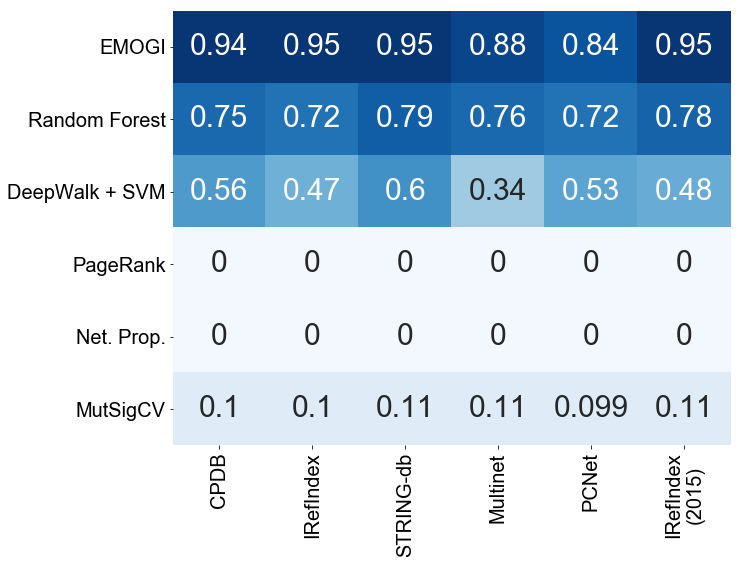

In [10]:
fig = plt.figure(figsize=(10, 8))
#cmap = sns.light_palette((240, 85, 50), input="husl", n_colors=50)#sns.color_palette("Blues")
cmap = sns.color_palette("Blues", n_colors=50)
sns.heatmap(metrics_all, cbar=False, cmap=cmap, cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
            annot=True, annot_kws={"size": 30, 'weight': 'medium'})
_ = plt.gca().set_xticklabels(metrics_all.columns, rotation=90, fontsize=20)
_ = plt.gca().set_yticklabels(metrics_all.index, rotation=0, fontsize=20)
tool_colors = ["darkred", "darkorange", "darkgreen", "darkblue", "grey", "purple"]
#[t.set_color(c) for (c,t) in zip(tool_colors, plt.gca().yaxis.get_ticklabels())]
#fig.savefig('/project/gcn/diseasegcn/data/GCN/training/final_TCGA_all_networks/aupr_heatmap.svg',
#            bbox_inches='tight')

## Overlap of Predictions from Different Tools

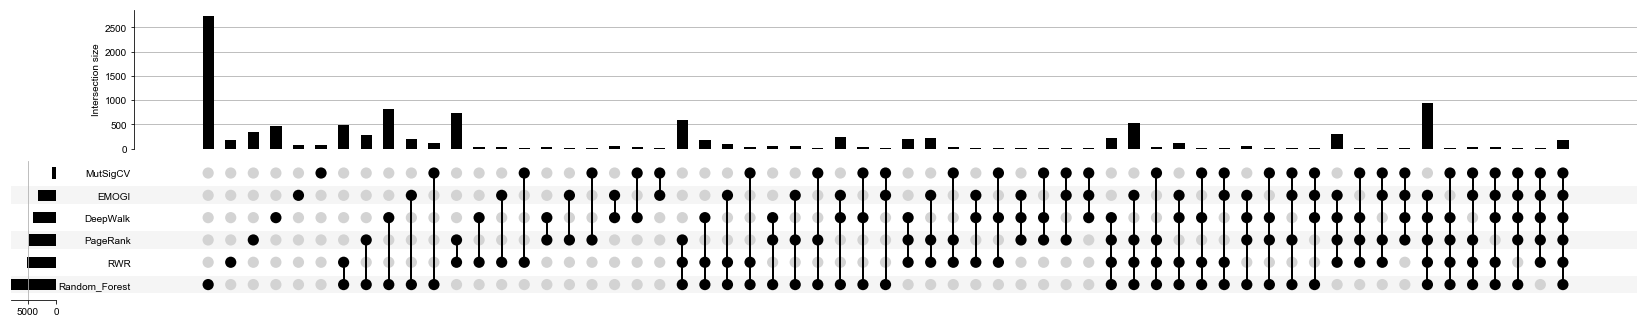

In [11]:
# 1. load data and compute cutoffs for all tools
model_dir = os.path.join(dir_cpdb, 'multiomics')
data = postprocessing.get_training_data(model_dir)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
performance_cpdb['Name'] = performance_cpdb.index # needed for cutoff computation
performance_cpdb['label'] = y_test

all_cutoffs = {}
for col in performance_cpdb.drop(['ID', 'Name', 'label'], axis=1).columns:
    cutoff = postprocessing.get_optimal_cutoff(performance_cpdb, node_names, test_mask, y_test, colname=col)
    all_cutoffs[col] = cutoff

# 2. compute positive sets for all tools
pos_predicted = {}
for col in performance_cpdb.drop(['ID', 'Name', 'label'], axis=1).columns:
    pos_pred = performance_cpdb[col] >= all_cutoffs[col]
    pos_predicted[col] = list(performance_cpdb[pos_pred].Name)

# 3. compute and display overlaps between all tools
plot_input = upsetplot.from_contents(pos_predicted)
fig = plt.figure(figsize=(20, 15))
upsetplot.plot(plot_input, subset_size='auto', fig=fig)
fig.savefig(os.path.join(model_dir, 'overlap_tool_prediction.svg'))

## Compute the Amount of Missed Cancer Genes when Leaving Out Data
Next, we want to compute quantitatively how many cancer genes we don't predict with EMOGI when we leave out certain data types.
We therefore either look at the omics levels individually or at combinations of two of them and compare them to the full EMOGI multiomics model.

In [17]:
all_networks_missed_cancer_genes = []
# compute for all apart Multinet
for ppi_network in ppi_networks:
    missed_single_omics = {}
    for omics_subset in os.listdir(training_runs[ppi_network]):
        training_dir = os.path.join(training_runs[ppi_network], omics_subset)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            data = postprocessing.get_training_data(training_dir)
            network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
            pred = postprocessing.load_predictions(training_dir)
            cutoff = postprocessing.get_optimal_cutoff(pred, node_names, test_mask, y_test, colname='Prob_pos')
            #pred = pred[y_test]
            neg_pred = pred[pred.Prob_pos >= cutoff]
            #print (neg_pred.label.sum(), neg_pred.shape[0])
            missed_single_omics[omics_subset] = [neg_pred.label.sum(), neg_pred.shape[0]]
    missed_cancer_gene_df = pd.DataFrame(missed_single_omics)
    all_networks_missed_cancer_genes.append(missed_cancer_gene_df)
    print ("Computed for {}".format(ppi_network))
    #break

Computed for CPDB
Computed for IREF (New)
Computed for STRING-db
Computed for Multinet
Computed for PCNet
Computed for IREF


In [18]:
all_networks_missed_cancer_genes[1]

,multiomics,mutations,expression,methylation,methylation_expression,methylation_mutation,mutation_expression
0,653,515,497,460,573,490,545
1,4134,3763,3847,3361,4103,2541,3258


(0.75, 1)

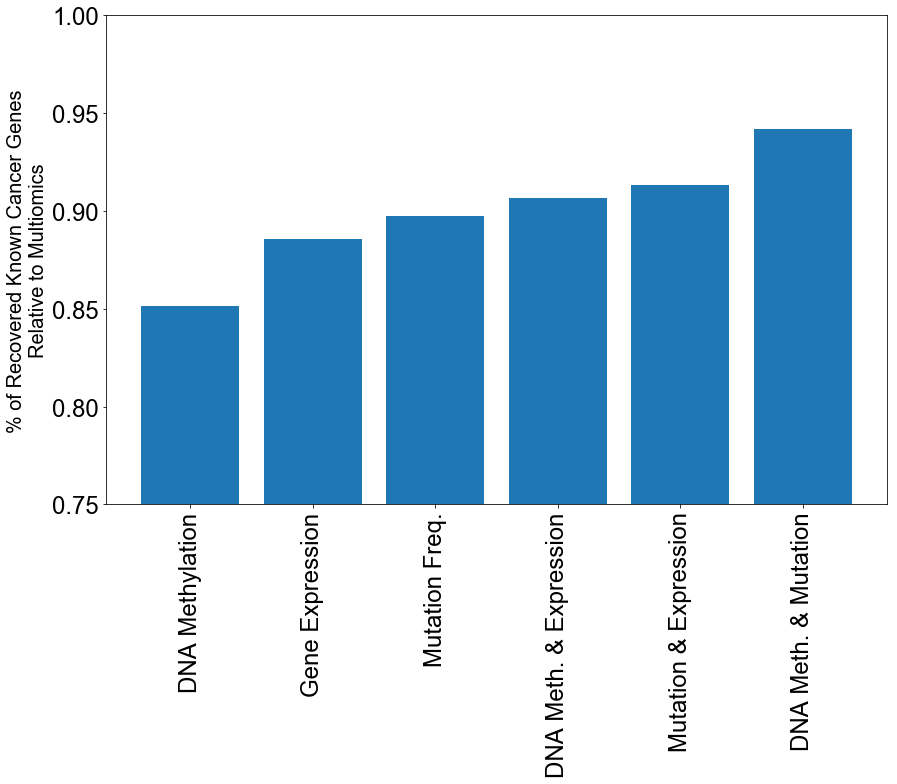

In [19]:
avg_misses = []
for net in all_networks_missed_cancer_genes:
    normed = net.div(net['multiomics'], axis='rows').T
    normed.columns = ['Frac_Missed_Cancer_Genes', 'Frac_Non_Predictions']
    normed.drop('multiomics', axis=0, inplace=True)
    #normed = (normed - 1) * 100 # to make multiomics setting be 0
    avg_misses.append(normed.Frac_Missed_Cancer_Genes)

std_misses = np.std(avg_misses, axis=0)
avg_misses = np.mean(avg_misses, axis=0)

fig = plt.figure(figsize=(14, 9))

replace_dict = {'expression': 'Gene Expression', 'methylation': 'DNA Methylation',
                'mutations': 'Mutation Freq.', 'multiomics': 'Multi-Omics',
                'mutation_expression': 'Mutation & Expression',
                'methylation_expression': 'DNA Meth. & Expression',
                'methylation_mutation': 'DNA Meth. & Mutation',
                'no_cna': 'No Copy Number', 'no_ge': 'No Gene Expr.',
                'no_meth': 'No DNA Meth.', 'no_snvs': 'No Mutation'
               }
normed_sorted = normed.index[np.argsort(avg_misses)]
misses_sorted = sorted(avg_misses)
ax = plt.bar(x=list(range(avg_misses.shape[0])), height=misses_sorted)#, yerr=std_misses)
_ = plt.xticks(list(range(avg_misses.shape[0])), labels=pd.Series(normed_sorted).replace(replace_dict),
               rotation=90, fontsize=24)
plt.yticks(fontsize=24)
#plt.ylabel('% of Missed Known Cancer Genes\nRelative to Multiomics', fontsize=20)
plt.ylabel('% of Recovered Known Cancer Genes\nRelative to Multiomics', fontsize=20)
plt.ylim([0.75, 1])
#fig.savefig(os.path.join('/project/gcn/diseasegcn/data/GCN/training/final_TCGA_all_networks/',
#                         'recovered_cancer_genes_singleomics.svg'))

## Prediction Performance for Single (and Dual) Omics Data

In [22]:
metric_of_choice = 'aupr'
gcn_training_path = dir_cpdb
used_network = 'CPDB'
reference = 'multiomics' # the reference training to use for the competing methods

# get metrics for GCN
gcn_all = get_metrics_for_training(gcn_training_path, metric=metric_of_choice,
                                   digsee_sets=True, errorbars=True)
gcn_all_array = np.array(gcn_all[0])
flattened_dfs = []
for cv_run in range(gcn_all_array.shape[-1]):
    df = pd.DataFrame(gcn_all_array[:, :, cv_run], index=gcn_all[1],
                      columns=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'])
    df['cv'] = cv_run
    flattened_dfs.append(df)
gcn_metrics = pd.concat(flattened_dfs)
gcn_metrics['Network'] = used_network
gcn_metrics['Method'] = gcn_metrics.index

# get metrics for HotNet2
hn2_m = compute_hotnet2_metrics(metric=metric_of_choice, digsee_sets=True)

# get metrics for DeepWalk + SVM
model_ref = os.path.join(gcn_training_path, reference)
path_reference_model = gcnIO.load_hyper_params(model_ref)[1]
path_reference_model = os.path.join(model_ref, path_reference_model)
dw_m = compute_deepwalk_metrics('../data/pancancer/deepWalk_results/{}_embedding_CPDBparams.embedding'.format(used_network.upper()),
                                path_reference_model, used_network,
                                metric=metric_of_choice, digsee_sets=True)

# get metrics for MutSigCV
mscv_m = get_metric_for_mutsigcv(os.path.join(gcn_training_path, reference),
                                 metric=metric_of_choice, digsee_sets=True)
mscv_df = pd.DataFrame(mscv_m, columns=['MutSigCV'],
                       index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr']).T

# get metrics for node degree
nd_m = compute_degree_metrics(os.path.join(dir_cpdb, reference), metric='aupr', digsee_sets=True)
nd_df = pd.DataFrame(nd_m, columns=['Node Degree'],
                     index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr']).T

digsee_metrics_competitors = pd.concat((gcn_metrics, dw_m, hn2_m, mscv_df, nd_df))

# get random metrics
def _get_random_metric(model_dir, dataset, metric='recall'):
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    if metric.upper() == 'AUPR' or metric.upper() == 'PRECISION':
        random_performance = len(dataset) / network.shape[0]
    elif metric.upper() == 'RECALL':
        return 0.5 # assuming that the classifier has probability of 0.5 to predict positive
    elif metric.upper() == 'F1':
        rand_precision = len(dataset) / network.shape[0]
        rand_recall = 0.5
        random_performance = 2 * ( (rand_precision*rand_recall) / (rand_precision + rand_recall) )
    else:
        print ("Metric {} not understood".format(metric))
    return random_performance

ds_sets = get_all_digsee_sets(os.path.join(gcn_training_path, reference))
rand_perfs = {}
count = 0
for i in ['Oncogenes\n(ONGene)', 'Bailey et al.\n(2018)', 'DigSee Expr.\nGenes']:#['DigSEE Mutation\nGenes', 'DigSEE Meth.\nGenes', 'DigSee Expr.\nGenes']:
    rand_perfs[i] = _get_random_metric(os.path.join(gcn_training_path, reference),
                                       ds_sets[count], metric=metric_of_choice)
    count += 1
onco, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(gcn_training_path, reference))
rand_perfs['NCG Known\nCancer Genes'] = _get_random_metric(os.path.join(gcn_training_path, reference), ncg_known, metric=metric_of_choice)
rand_perfs['NCG Candidate\nCancer Genes'] = _get_random_metric(os.path.join(gcn_training_path, reference), ncg_cand, metric=metric_of_choice)
rand_perfs['OncoKB Genes\n(not in NCG)'] = _get_random_metric(os.path.join(gcn_training_path, reference), onco, metric=metric_of_choice)

/home/sasse/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [25]:
rand_network_path = '../data/GCN/training/2019_08_27_11_32_33/Random_powerlaw_perturbation/'
rand_net_metrics = get_metrics_for_single_training(rand_network_path, metric='aupr',
                                                   errorbars=True, digsee_sets=True)
rand_net_df = pd.DataFrame(np.array(rand_net_metrics),
                           index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                           columns=['CV_{}'.format(i) for i in range(5)]
                          ).T
rand_net_df['Network'] = 'CPDB'
rand_net_df['Method'] = 'Randomized Network'
rand_net_df['cv'] = range(5)
gcn_metrics = pd.concat((gcn_metrics, rand_net_df))

/home/sasse/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Bailey et al.
(2018)
Oncogenes
(ONGene)
NCG Candidate
Cancer Genes
NCG Known
Cancer Genes
OncoKB Genes
(not in NCG)


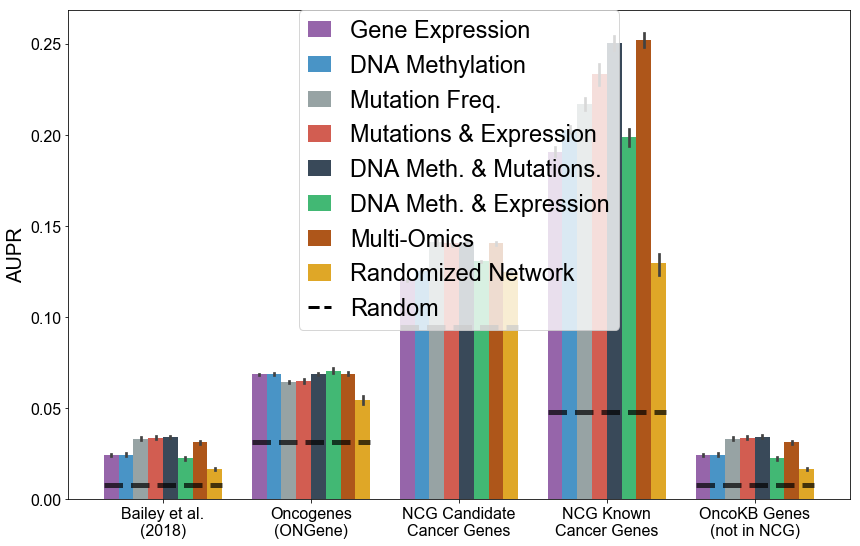

In [26]:
fig = plt.figure(figsize=(14, 9))
replace_dict = {'expression': 'Gene Expression', 'methylation': 'DNA Methylation',
                'mutations': 'Mutation Freq.', 'multiomics': 'Multi-Omics',
                'mutation_expression': 'Mutations & Expression',
                'methylation_expression': 'DNA Meth. & Expression',
                'methylation_mutation': 'DNA Meth. & Mutations.',
                'no_cna': 'No Copy Number', 'no_ge': 'No Gene Expr.',
                'no_meth': 'No DNA Meth.', 'no_snvs': 'No Mutation'
               }
col_replace_dict = {'DS_Expr': 'DigSee Expr.\nGenes', #'DS_Meth': 'DigSEE Meth.\nGenes', 'DS_Mut': 'DigSEE Mutation\nGenes',
                    'NCG_Known': 'NCG Known\nCancer Genes',
                    'NCG_Cand': 'NCG Candidate\nCancer Genes', 'OncoKB': 'OncoKB Genes\n(not in NCG)',
                    'DS_Mut': 'Oncogenes\n(ONGene)', 'DS_Meth': 'Bailey et al.\n(2018)'
                   }
gcn_metrics_copy = gcn_metrics.copy().drop('DS_Expr', axis=1)
gcn_metrics_copy.rename(mapper=col_replace_dict, axis=1, inplace=True)
metrics_melted = gcn_metrics_copy.drop('Network', axis=1).melt(id_vars=['Method', 'cv'])
metrics_melted.Method = metrics_melted.Method.replace(replace_dict)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui) + sns.xkcd_palette(["dark orange","amber", "faded green",
                                                       "dusty purple", "pink",  "black", "light green", "dark blue", "light blue", "light yellow"])

p = sns.barplot(data=metrics_melted, x='variable', y='value', hue='Method', palette=colors)
#_ = sns.swarmplot(data=metrics_melted, x='variable', y='value', hue='Method')

group = 0
for group_name in metrics_melted.variable.unique():
    print (group_name)
    plt.plot([group-0.4, group+0.4], [rand_perfs[group_name], rand_perfs[group_name]],
             ls='--', lw=5, alpha=.7, c='black')
    group += 1

rand_handle = Line2D([0], [0], color='black', linewidth=3, linestyle='--')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(rand_handle)
labels.append('Random')

plt.ylabel('{}'.format(metric_of_choice.upper()), fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=16)
legend = plt.legend(loc='upper center', borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=2.5, handles=handles, labels=labels)
#legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
#                    markerscale=2.5, handles=handles, labels=labels)
#fig.savefig(os.path.join(gcn_training_path, '{}_singleomics_candidates_oncokb_ongene_bailey.svg'.format(metric_of_choice)), bbox_inches='tight')

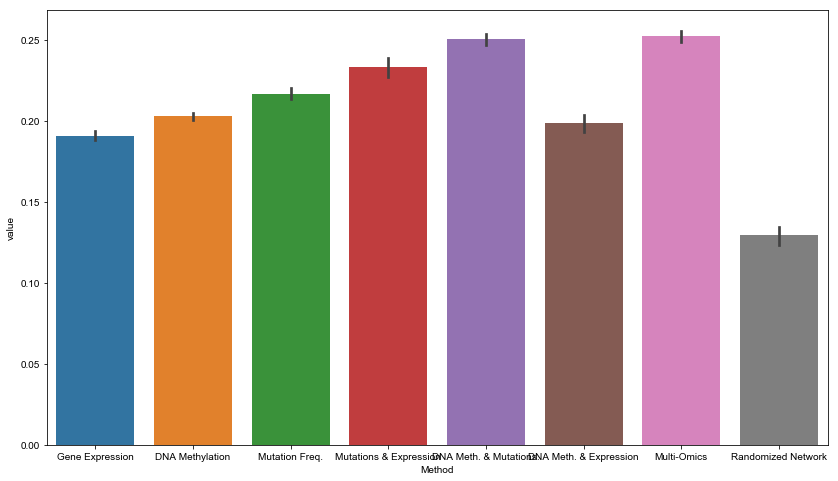

In [27]:
metrics_melted = metrics_melted[metrics_melted.variable == 'NCG Known\nCancer Genes']
fig = plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_melted, y='value', x='Method')

## Plot Performance for Independent Data Sets

In [28]:
metric_of_choice = 'aupr'

print ("Computing EMOGI performance")
training_runs = {'Multinet': dir_multinet,
                 'CPDB': dir_cpdb,
                 'IREF':dir_iref,
                 'STRING-db': dir_string,
                 'IREF (New)': dir_irefnew,
                 'PCNet': dir_pcnet
                }
all_metrics = []
for network_name in training_runs:
    metrics, omics = get_metrics_for_training(training_runs[network_name], metric=metric_of_choice, digsee_sets=False)
    x = pd.DataFrame(metrics, index=omics,
                     columns=['NCG_Cand', 'OncoKB'])
    x['Network'] = network_name
    all_metrics.append(x)
all_metrics_df = pd.concat(all_metrics)
all_metrics_df['Method'] = all_metrics_df.index

# get mutsigcv metrics
print ("Loading MutSigCV performance")
mutsigcv_perf = []
for network_name, network_dir in {'Multinet': dir_multinet, 'CPDB': dir_cpdb, 'IREF':dir_iref}.items():
    ms_perf_known, ms_perf_cand = get_metric_for_mutsigcv(os.path.join(network_dir, 'multiomics'), metric=metric_of_choice)
    mutsigcv_perf.append([ms_perf_known, ms_perf_cand, network_name])
mutsig_perf_df = pd.DataFrame(mutsigcv_perf, columns=['NCG_Cand', 'OncoKB', 'Network'])
mutsig_perf_df['Method'] = 'MutSigCV'
mutsig_perf_df.set_index('Method', inplace=True)
mutsig_perf_df['Method'] = 'MutSigCV'

# compute metrics for HotNet2 results
print ("Computing HotNet2 metrics")
hotnet2_perf = compute_hotnet2_metrics(metric=metric_of_choice)

# compute metrics for deepwalk
print ("Computing DeepWalk metrics")
dw_resdir = '../data/pancancer/deepWalk_results/'
input_basedir = '../data/pancancer/'
dw_paths = {'IREF': ('IREF_embedding_CPDBparams.embedding', 'multiomics_containers/IREF_multiomics.h5'),
            'Multinet': ('MULTINET_embedding_CPDBparams.embedding', 'all_omics_multinet/MULTINET_multiomics.h5'),
            'CPDB': ('CPDB_embedding_CPDBparams.embedding', 'CPDB_multiomics_omimallneg.h5'),
            'STRING-db':('STRING_embedding_CPDBparams.embedding', 'all_omics_final_STRING/STRING_multiomics.h5'),
            'IREF (New)': ('IREFNEW_embedding_CPDBparams.embedding', 'all_omics_final_IREFNew/IREFNew_multiomics.h5'),
            'PCNet': ('PCNET_embedding_CPDBparams.embedding', 'all_omics_final_PCNET/PCNET_multiomics.h5')
           }
dw_dfs = []
for key in dw_paths:
    res, inp = dw_paths[key]
    dw_dfs.append(compute_deepwalk_metrics(os.path.join(dw_resdir, res),
                                           os.path.join(input_basedir, inp),
                                           network_name=key,
                                           metric=metric_of_choice)
                  )
dw_perf = pd.concat((dw_dfs))

# compute metrics for PageRank
print ("Computing PageRank metrics")
pr_metrics = []
for network_name in training_runs:
    pr_metrics.append(compute_PR_metrics(model_dir=os.path.join(training_runs[network_name], 'multiomics'),
                                         network_name=network_name,
                                         metric=metric_of_choice,
                                         digsee_sets=False
                                        )
                     )
pr_perf = pd.concat(pr_metrics)

# compute metrics for random forest
print ("Computing RandomForest metrics")
rf_metrics = []
for network_name in training_runs:
    rf_metrics.append(compute_RF_metrics(model_dir=os.path.join(training_runs[network_name], 'multiomics'),
                                         network_name=network_name,
                                         metric=metric_of_choice,
                                         digsee_sets=False
                                        )
                     )
rf_perf = pd.concat(rf_metrics)


# compute metrics for network propagation
print ("Computing Network propagation metrics")
netprop_metrics = []
for network_name in training_runs:
    netprop_metrics.append(compute_netprop_metrics(model_dir=os.path.join(training_runs[network_name], 'multiomics'),
                                         network_name=network_name,
                                         metric=metric_of_choice,
                                         digsee_sets=False
                                        )
                     )
netprop_perf = pd.concat(netprop_metrics)

all_metrics_df = pd.concat((all_metrics_df, mutsig_perf_df, hotnet2_perf, dw_perf, pr_perf, rf_perf, netprop_perf))

Computing EMOGI performance
Loading MutSigCV performance
Computing HotNet2 metrics
Computing DeepWalk metrics
Computing PageRank metrics
Computing RandomForest metrics
Computing Network propagation metrics


/home/sasse/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:94: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [29]:
all_metrics_df.groupby('Method').mean()

,NCG_Cand,OncoKB
Method,,
DeepWalk + SVM,0.124,0.022
Hotnet2 (Frequency Scores),0.100,0.009
Hotnet2 (MutSig Scores),0.089,0.011
MutSigCV,0.102,0.065
Net. Prop. (Mut. Freq.),0.125,0.026
PageRank,0.107,0.023
Random Forest,0.164,0.019
expression,0.121,0.026
methylation,0.118,0.024


/home/sasse/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


8 6


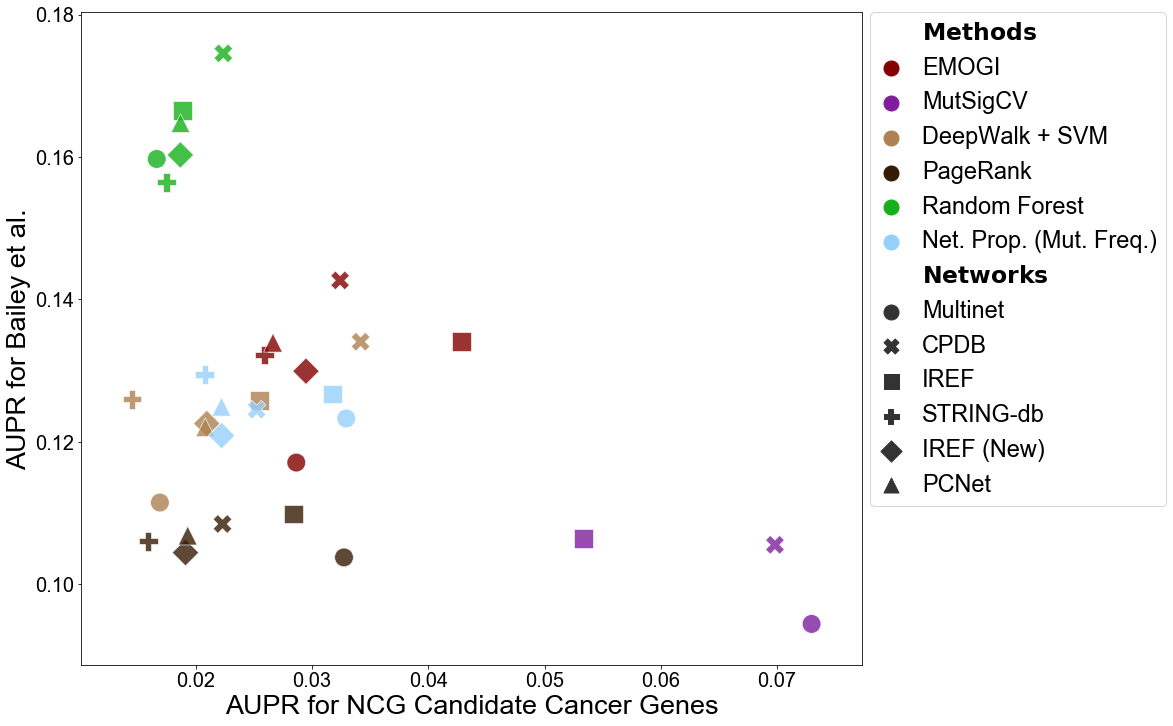

In [30]:
fig = plt.figure(figsize=(14, 12))
replace_dict = {'expression': 'EMOGI (Expression only)', 'methylation': 'EMOGI (Methylation only)',
                'mutations': 'EMOGI (Mutation Frequency only)', 'multiomics': 'EMOGI',
                'mutation_expression': 'EMOGI (No Methylation)',
                'methylation_expression': 'EMOGI (No Mutation)',
                'methylation_mutation': 'EMOGI (No Expression)',
                'no_cna': 'EMOGI (No CNA)', 'no_ge': 'EMOGI (No Expression)',
                'no_meth': 'EMOGI (No Methylation)', 'no_snvs': 'EMOGI (No Mutation)'
               }

network_names = {'IREF': 'IRefIndex (2015)', 'IREF (NEW)': 'IRefIndex'}

all_metrics_df_relevant = all_metrics_df[all_metrics_df.index.isin(['multiomics',#'no_snvs', 'no_cna',
                                                                    #'expression_mutation', 'mutations',
                                                                    'MutSigCV', 'DeepWalk', 'PageRank',
                                                                    'RF', 'NetProp'])]

all_metrics_df.Method = all_metrics_df.Method.replace(replace_dict)
all_metrics_df_relevant.Method = all_metrics_df_relevant.Method.replace(replace_dict)

colors = sns.xkcd_palette(["dark red", "purple", "light brown", "dark brown", "green", "light blue", "pink", 'grey'])
print (len(colors), all_metrics_df_relevant.Method.nunique())

sns.scatterplot(data=all_metrics_df_relevant,
                x='OncoKB',
                y='NCG_Cand',
                hue='Method', style='Network',
                alpha=.8, s=350, palette=colors[:all_metrics_df_relevant.Method.nunique()])
plt.ylabel('{} for Bailey et al.'.format(metric_of_choice.upper()), fontsize=27)
plt.xlabel('{} for NCG Candidate Cancer Genes'.format(metric_of_choice.upper()), fontsize=27)
#plt.ylabel('{} for Tumor Suppressor Genes (TSGene DB)'.format(metric_of_choice.upper()), fontsize=27)
plt.tick_params(axis='both', labelsize=20)
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=2.5)
legend.texts[0].set_text(r"$\bf{Methods}$")
legend.texts[all_metrics_df_relevant.Method.nunique()+1].set_text(r"$\bf{Networks}$")
#fig.savefig('../data/pancancer/ensemble_metrics_{}_onkb_vs_oncogenes.svg'.format(metric_of_choice), bbox_inches="tight")
#fig.savefig('../data/pancancer/ensemble_metrics_{}_bailey_vs_candidates.svg'.format(metric_of_choice), bbox_inches="tight")

In [31]:
data = postprocessing.get_training_data(os.path.join(dir_cpdb, 'multiomics'))
comprehensive, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(dir_cpdb, 'multiomics'))
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
get_hotnet2_results()['iRefIndex_Frequency']
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes[nodes.Name.isin(get_hotnet2_results()['iRefIndex_Frequency'])].head()

,ID,Name
18,ENSG00000146648,EGFR
20,ENSG00000121879,PIK3CA
88,ENSG00000284792,PTEN
89,ENSG00000141510,TP53
117,ENSG00000165891,E2F7


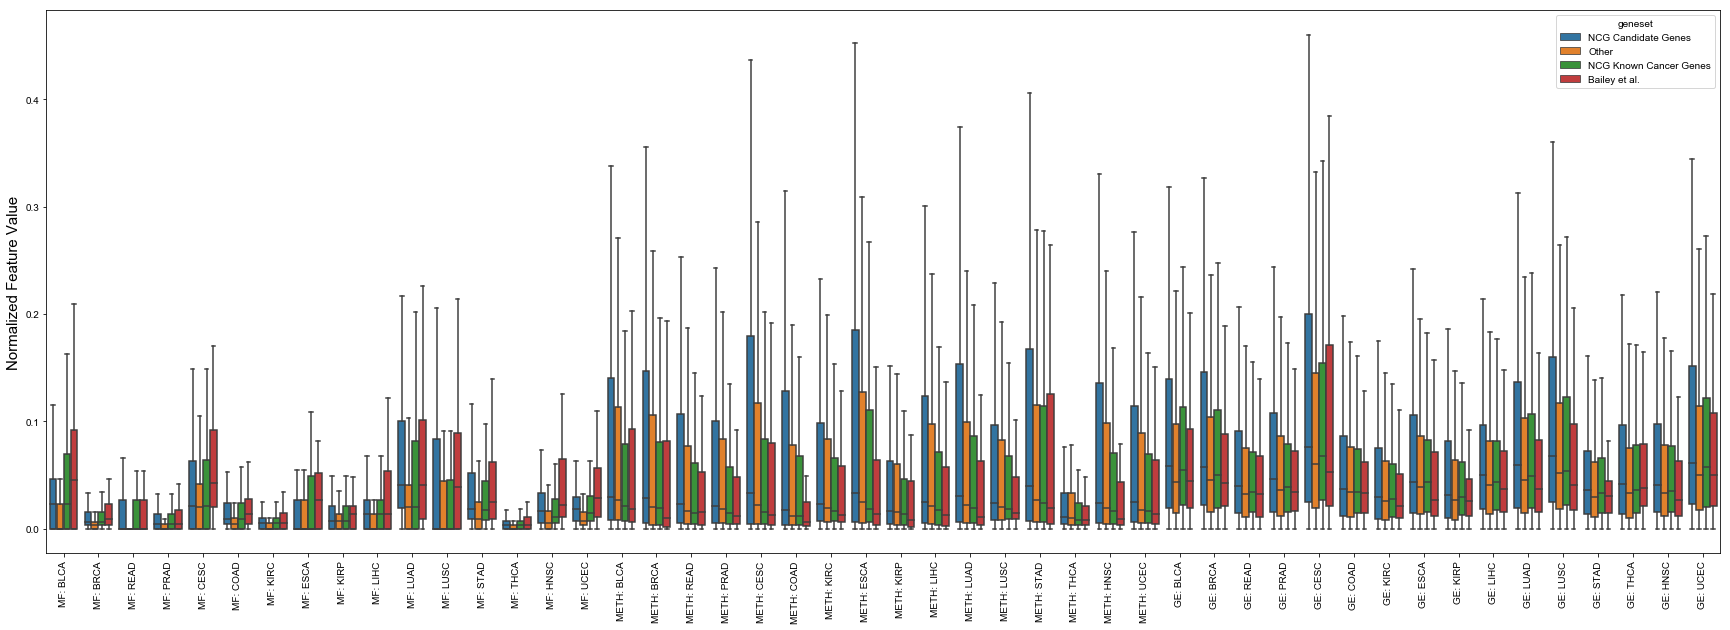

In [32]:
data = postprocessing.get_training_data(os.path.join(dir_cpdb, 'multiomics'))
comprehensive, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(dir_cpdb, 'multiomics'))
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
F = pd.DataFrame(features, index=node_names[:, 1], columns=feat_names)

# construct a feature df and melt it
F['geneset'] = 'Other'
F.loc[F.index.isin(ncg_known), 'geneset'] = 'NCG Known Cancer Genes'
F.loc[F.index.isin(ncg_cand), 'geneset'] = 'NCG Candidate Genes'
F.loc[F.index.isin(comprehensive), 'geneset'] = 'Bailey et al.'
x = F.melt(id_vars=['geneset'])

# plot
fig = plt.figure(figsize=(30, 10))
sns.boxplot(data=x, x='variable', y='value', hue='geneset', showfliers=False)
plt.xticks(rotation=90)
plt.ylabel('Normalized Feature Value', fontsize=15)
plt.xlabel(None)
fig.savefig(os.path.join(dir_cpdb, 'feature_distro_genesets.pdf'))